In [2]:
# Importando bibliotecas utilizadas no projeto
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
dataset = 'Tomato pest image enhancement'
height, width = 299, 299
batch_size = 32
SEED = 123
training = keras.utils.image_dataset_from_directory(
    dataset,
    labels='inferred',
    validation_split=.2,
    image_size=(height, width),
    class_names = None,
    subset='training',
    seed=SEED,
    label_mode='categorical'
)

Found 4263 files belonging to 8 classes.
Using 3411 files for training.


In [4]:
validation = keras.utils.image_dataset_from_directory(
    dataset,
    labels='inferred',
    validation_split=.2,
    image_size=(height, width),
    class_names = None,
    subset='validation',
    seed=SEED,
    label_mode='categorical'
)

Found 4263 files belonging to 8 classes.
Using 852 files for validation.


In [5]:
class_names = training.class_names

In [6]:
base_model = keras.applications.ResNet50(
    include_top=False,
    input_shape = (height, width, 3),
    pooling='avg',
    classes=8,
    weights='imagenet'
)
for layer in base_model.layers:
    layer.trainable = False

In [7]:
model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(8, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
history = model.fit(training, validation_data=validation, epochs=5)

Epoch 1/5
107/107 [==============================] - 30s 225ms/step - loss: 0.7051 - accuracy: 0.7608 - val_loss: 0.3313 - val_accuracy: 0.8991
Epoch 2/5
107/107 [==============================] - 21s 199ms/step - loss: 0.1741 - accuracy: 0.9502 - val_loss: 0.2359 - val_accuracy: 0.9167
Epoch 3/5
107/107 [==============================] - 22s 203ms/step - loss: 0.0838 - accuracy: 0.9780 - val_loss: 0.1597 - val_accuracy: 0.9519
Epoch 4/5
107/107 [==============================] - 22s 204ms/step - loss: 0.0393 - accuracy: 0.9924 - val_loss: 0.1194 - val_accuracy: 0.9648
Epoch 5/5
107/107 [==============================] - 22s 204ms/step - loss: 0.0230 - accuracy: 0.9956 - val_loss: 0.1083 - val_accuracy: 0.9648


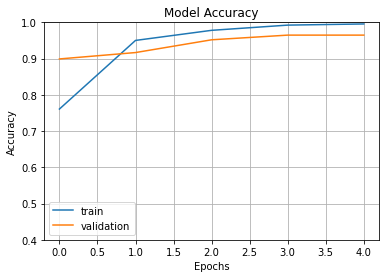

In [10]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1) 
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [11]:
validation.class_names

['BA', 'HA', 'MP', 'SE', 'SL', 'TP', 'TU', 'ZC']

In [40]:
import cv2
image=cv2.imread(f'{dataset}/BA/BA (1).jpg')
image=np.expand_dims(image,axis=0)  

(1, 299, 299, 3)

In [39]:
prediction = model.predict(image)
validation.class_names[np.argmax(prediction)]

'BA'

In [48]:
img = keras.preprocessing.image.load_img(f'{dataset}/BA/BA (1).jpg', target_size=(height, width,3))
keras.preprocessing.image.img_to_array(img).shape

(299, 299, 3)

In [96]:
files = validation.file_paths
ba = [file for file in files if 'ZC' in file]
correct = 0
for path in ba:
    image=cv2.imread(path)
    image=np.expand_dims(image,axis=0)
    prediction = model.predict(image)
    if class_names[np.argmax(prediction)] == 'ZC':
        correct += 1
print(correct)

55


In [97]:
len(ba)

58